<a href="https://colab.research.google.com/github/simonjayet/formation_deep_learning/blob/master/MNIST/MNIST_CNN_Entrainement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Réseau neuronal convolutif

Les [réseaux de neurones à convolution](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif) (Convolutional Neural Networks - CNNs) ont de larges applications, en particulier dans la reconnaissance d'image et de vidéo. Leur structure est inspirée par celle du cortex visuel des animaux.

Cet exemple nécessite Python 3, Tensorflow 2, matplotlib, et numpy. Entrainer un réseau de neurones à convolution demande davantage de temps de calcul qu'un réseau de base, entièrement connecté. C'est la raison pour laquelle l'entrainement par GPU est préféré.

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import numpy as np
import random

Quelques configurations des paramètres et des hyperparamètres.

In [2]:
# Dimensions des images d'entrée : 28x28
dim_img_lignes, dim_img_colonnes = 28, 28

# Nombre d'échantillons d'entrainement par lot. 128 est un nombre raisonable
batch_size = 128

# Les données contiennent 10 chiffres
nbr_classes = 10

# Nombre d'itérations à utiliser.
iterations = 5

# dropout est un hyperparamètre de régularisation. Il permet d'éviter la mémorisation pure et simple des entrées.
dropout = 0.5

### Chargement des données

Keras possède des fonctions intégrées pour charger la base données MNIST, qui est par défaut structurée avec des données réservées pour l'entrainement et les tests.  
* x_entrainement and x_test sont les variables utilisées pour sauvegarder les échantillons d'entrainement et de tests. Les images sont représentées dans une matrice de 28x28 pixels.  
* y_entrainement et y_test sont les variables utilisées pour sauvegarder les valeurs attendues (les labels qui correspondent à chaque image manuscrite, c'est-à-dire le chiffre correspondant) d'entrainement et de tests.

In [3]:
(x_entrainement, y_entrainement), (x_test, y_test) = mnist.load_data()

# Sauvegarde des échantillons des images de tests dans une variable intermédiaire 
# pour regarder un peu comment ces données sont structurées
orig_test = x_test

11501568/11490434 [==============================] - 0s 0us/step


La cellule suivante permet de visualiser des images réservées aux tests au hasard afin de se faire une idée de ce à quoi elles ressemblent.

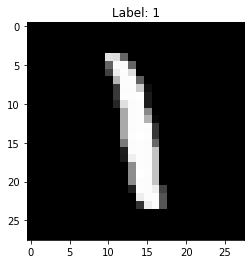

In [4]:
index = random.randrange(1000)
plt.imshow(orig_test[index], cmap='gray')
plt.title('Label: %d' % y_test[index])
plt.show()

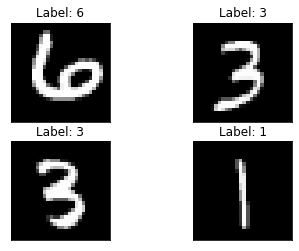

In [5]:
rows = 2
columns = 2

fig, axs = plt.subplots(rows, columns)

for c in range(columns):
  for r in range(rows):
    index = random.randrange(1000)
    axs[r, c].imshow(orig_test[index], cmap='gray')
    axs[r, c].set_title('Label: %d' % y_test[index])
    axs[r, c].axes.get_xaxis().set_visible(False)
    axs[r, c].axes.get_yaxis().set_visible(False)




In [34]:
y_test[0]

7

### Préparation des données

Les données sont structurées afin d'être compatibles avec la forme d'entrée attendue par Keras :
*  Soit du type : (RGB, X, Y)  
*  Soit du type : (X, Y, RGB)  

La valeur des pixels sont normalisées entre 0.0 et 1.0.

In [6]:
if K.image_data_format() == 'channels_first':
    x_entrainement = x_entrainement.reshape(x_entrainement.shape[0], 1, dim_img_lignes, dim_img_colonnes)
    x_test = x_test.reshape(x_test.shape[0], 1, dim_img_lignes, dim_img_colonnes)
    input_shape = (1, dim_img_lignes, dim_img_colonnes)
else:
    x_entrainement = x_entrainement.reshape(x_entrainement.shape[0], dim_img_lignes, dim_img_colonnes, 1)
    x_test = x_test.reshape(x_test.shape[0], dim_img_lignes, dim_img_colonnes, 1)
    input_shape = (dim_img_lignes, dim_img_colonnes, 1)
    
x_entrainement, x_test = x_entrainement / 255.0, x_test / 255.0

print(x_entrainement.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [40]:
#x_entrainement[0]
#x_entrainement.shape
#x_entrainement.reshape(x_entrainement.shape[0], 1, dim_img_lignes, dim_img_colonnes)
#x_entrainement.reshape(x_entrainement.shape[0], 1, dim_img_lignes, dim_img_colonnes).shape
input_shape

(28, 28, 1)

### Definition du modèle

Des modèles avec plus de 100 réseaux de neurones à convolution, des couches de  pooling, padding, et autres couches ont permis d'être entrainés avec succès afin de reconnaitre des objets complexes ainsi que de multiples objets dans une image.

La structure du modèle que nous allons utliser est la suivante :  
* Deux [couches de convolution 2D](https://keras.io/api/layers/convolution_layers/convolution2d/) avec des fonctions d'activation de type redresseur (ReLU) ;  
* Une [couche de pooling max](https://keras.io/api/layers/pooling_layers/max_pooling2d/) suivie d'une couche de régularisation de type [dropout](https://keras.io/api/layers/regularization_layers/dropout/) ;
*  Une [couche d'aplatissement](https://keras.io/api/layers/reshaping_layers/flatten/) ;
* Une [couche dense](https://keras.io/api/layers/core_layers/dense/) avec une fonction d'activation de type redresseur (ReLU) ;  
* Une régularisation de type [dropout](https://keras.io/api/layers/regularization_layers/dropout/) ;
* Une [couche dense](https://keras.io/api/layers/core_layers/dense/) avec une fonction d'activation de type Soft-Max. Cette dernière couche réalise la classification de type "1 parmi n" (One-hot encoded).  
  
Avec seulement des quelques couches, ce modèle permet d'attendre une précision de 99 %.  
La structure de notre modèle peut être visualisée comme ci-dessous :  
![ReseauNeurone](Images/ReseauConvolutionKeras.jpg "ReseauNeurone")


In [44]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='ReLU'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=nbr_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1179776   
                                                      

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout/2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(nbr_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

### Entrainement du modèle

Le code qui suit passe les données d'entrainement à Keras pour entrainer le modèle. La librairie Matplotlib est utilisée pour afficher la précision des entrainements et des tests, en fonction des itérations.

Dans l'idéal, la précision obtenue avec les données de tests et d'entrainements devrait être la même.  
* Une faible précision obtenue avec les données d'entrainements signifie que le modèle souffre d'un biais important. Cela peut être dû à un modèle qui n'est pas assez robuste, ou un manque de données d'entrainements, ou un trop petit nombre d'itérations.  
* Une grande précision obtenue avec des données d'entrainements mais une faible précision obtenue avec les données de tests signifie que le modèle souffre d'une variance élevée. Le modèle est plus ou moins en train de mémoriser les données et non d'apprendre réellement. Ce problème peut être réglé à l'aide de régularisations.

Epoch 1/10
469/469 [==============================] - 5s 9ms/step - loss: 0.0438 - accuracy: 0.9868 - val_loss: 0.0367 - val_accuracy: 0.9879
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0372 - accuracy: 0.9884 - val_loss: 0.0252 - val_accuracy: 0.9930
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0308 - accuracy: 0.9899 - val_loss: 0.0261 - val_accuracy: 0.9922
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0291 - accuracy: 0.9908 - val_loss: 0.0260 - val_accuracy: 0.9927
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0248 - accuracy: 0.9915 - val_loss: 0.0281 - val_accuracy: 0.9919
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0255 - val_accuracy: 0.9922
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0250 - val_accuracy: 0.9921
Epoch 

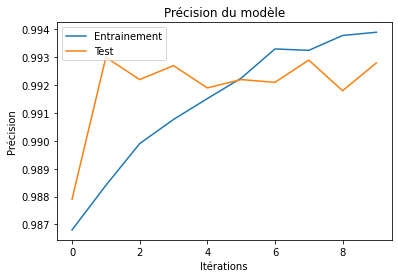

In [9]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Entraine le modèle sur un certain nombre d'itérations
historique = model.fit(x_entrainement, y_entrainement, batch_size=batch_size, epochs=10, verbose=1, validation_data=(x_test, y_test))

# Evalue la précision du modèle avec les données de tests
score = model.evaluate(x_test, y_test, verbose=0)
print('Pertes (Test) :', score[0])
print('Précision (Test) :', score[1])

# Affiche les informations
plt.plot(historique.history['accuracy'])
plt.plot(historique.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itérations')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

### Prédictions

Réalisons maintenant quelques prédictions en utilisant le modèle entrainé précédent.


In [10]:
predictions = model.predict(x_test)
plus_probable = predictions.argmax(1)

In [11]:
predictions

array([[4.7066225e-20, 1.0472527e-13, 2.9169349e-12, ..., 1.0000000e+00,
        2.6253963e-17, 8.3273400e-13],
       [1.4033562e-16, 3.9680283e-11, 1.0000000e+00, ..., 1.0243126e-14,
        2.9384288e-19, 3.8381248e-19],
       [4.4340235e-15, 1.0000000e+00, 2.0956875e-11, ..., 4.3492762e-10,
        7.4185493e-13, 1.7088744e-12],
       ...,
       [1.1455399e-22, 6.4932169e-15, 1.8480709e-17, ..., 5.1908494e-13,
        6.9649558e-15, 2.3918992e-11],
       [2.5391841e-15, 3.0192444e-16, 6.0755059e-20, ..., 8.6441036e-19,
        8.2756357e-11, 1.1670025e-14],
       [2.1403977e-12, 2.6497239e-14, 4.9188503e-15, ..., 1.7037073e-22,
        1.4303291e-11, 3.1436641e-16]], dtype=float32)

In [12]:
plus_probable

array([7, 2, 1, ..., 4, 5, 6])

In [13]:
predictions[0]

array([4.7066225e-20, 1.0472527e-13, 2.9169349e-12, 7.0514471e-13,
       3.3749374e-16, 1.5318124e-17, 3.1145534e-22, 1.0000000e+00,
       2.6253963e-17, 8.3273400e-13], dtype=float32)

La cellule suivante choisit une image au hasard parmi les images de tests, affiche l'image ainsi que les valeurs prédites et attendues (label).

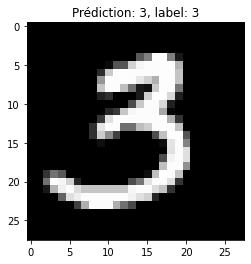

In [28]:
index = random.randrange(10000)
plt.title('Prédiction: %d, label: %d' % (plus_probable[index], y_test[index]))
plt.imshow(orig_test[index], cmap='gray')
plt.show()

### Analyse des erreurs

Cette dernière cellule recherche les prédictions du modèle qui n'ont pas fonctionnées. Dans certains cas, même un humain ne pourrait trouver la bonne réponse !

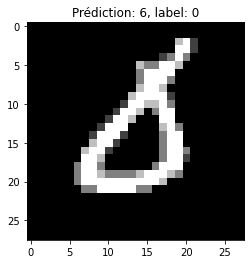

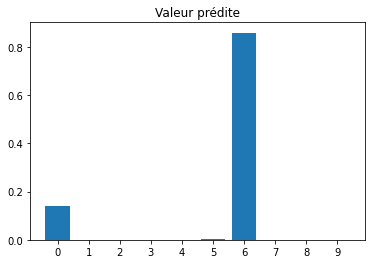

In [31]:
for i in range(10000):
    index = random.randrange(10000)
    if plus_probable[index] != y_test[index]:
        
        break

plt.imshow(orig_test[index], cmap='gray')
plt.title('Prédiction: %d, label: %d' % (plus_probable[index], y_test[index]))
plt.show()

plt.bar(range(10), predictions[index], tick_label=range(10))
plt.title('Valeur prédite')
plt.show()